<a href="https://colab.research.google.com/github/JeremiaSusanto/Latihan-Fork/blob/main/GLCM_FEATURE_EXTRACTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Downloader via Roboflow

download image that has been bounded box help by roboflow

In [53]:
!pip install roboflow

In [54]:
!rm -r /content/RoadCrack-2

rm: cannot remove '/content/RoadCrack-2': No such file or directory


In [55]:
import os
import json
from roboflow import Roboflow
rf = Roboflow(api_key="4V6T95yomp7w4ccYHkYr")
project = rf.workspace("foreveyrone").project("roadcrack-4xqqm")
version = project.version(3)
dataset = version.download("voc")

loading Roboflow workspace...
loading Roboflow project...


In [56]:
!pip install opencv-python

In [57]:
!pip install pillow

# Cut Image based on bounding box

In [58]:
!mkdir /content/cropped/
!mkdir /content/cropped/retak
!mkdir /content/cropped/tidak-retak

mkdir: cannot create directory ‘/content/cropped/’: File exists
mkdir: cannot create directory ‘/content/cropped/retak’: File exists
mkdir: cannot create directory ‘/content/cropped/tidak-retak’: File exists


In [59]:
import xml.etree.ElementTree as ET
from PIL import Image
# tree = ET.parse('data.xml')
# root = tree.getroot()

dir = os.listdir("/content/RoadCrack-3/train")
for i in dir:
  if ".xml" in i:
    with open(f"/content/RoadCrack-3/train/{i}") as f:
      content = f.read().strip()
      value = ET.fromstring(content)
      if not value.find(".//bndbox/xmin") is None:
        paths = f"/content/RoadCrack-3/train/{value.find('path').text}"
        xmin = int(value.find(".//bndbox/xmin").text)
        xmax = int(value.find(".//bndbox/xmax").text)
        ymin = int(value.find(".//bndbox/ymin").text)
        ymax = int(value.find(".//bndbox/ymax").text)
        img = Image.open(paths)
        cropped_img = img.crop((xmin, ymin, xmax, ymax)).resize((64*4, 64*4))
        classifier = value.find(".//name").text
        cropped_img.save(f"/content/cropped/{classifier}/cropped_{value.find('path').text}")
        # if cropped_img:
          # cv2.imwrite(f"/content/cropped/cropped_{paths}", cropped_img)


In [60]:
!ls /content/cropped/cropped_IMG_20251113_143926_jpg.rf.6b037bbfd44fbba61dd2abc72d898d36.jpg

ls: cannot access '/content/cropped/cropped_IMG_20251113_143926_jpg.rf.6b037bbfd44fbba61dd2abc72d898d36.jpg': No such file or directory


# GLCM Features

Contrast, Dissimilarity, Homogeneity, Energy and Correlation

In [61]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage import data, io, feature, util, transform
from matplotlib import pyplot as plt

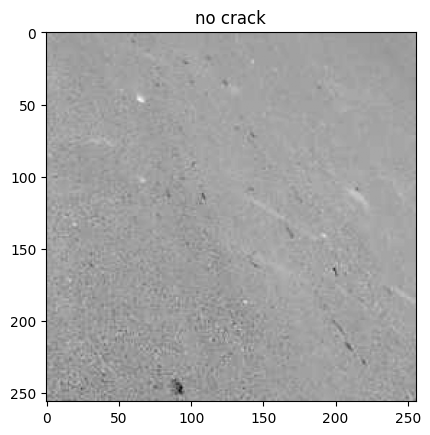

In [62]:
example = "/content/cropped/tidak-retak/cropped_IMG_20251123_160924_3_jpg.rf.bb5b566121c9b45df04b85f27e7ba141.jpg"
im_frame = Image.open(example).resize((64*4, 64*4))
image = (255*rgb2gray(np.array(im_frame))).astype(np.uint8)
imaged = util.img_as_ubyte(image)

plt.imshow(imaged, cmap='gray')
plt.title(f'no crack')
plt.show()

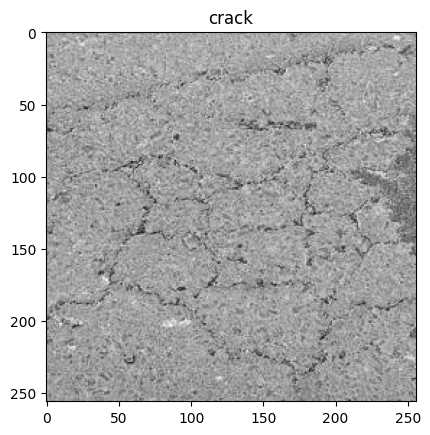

In [63]:
example = "/content/cropped/retak/cropped_IMG_20251106_150643_jpg.rf.c06a0746cde2bb34bbfe60f76420f6b7.jpg"
im_frame = Image.open(example).resize((64*4, 64*4))
image = (255*rgb2gray(np.array(im_frame))).astype(np.uint8)
imaged = util.img_as_ubyte(image)

plt.imshow(imaged, cmap='gray')
plt.title(f'crack')
plt.show()

# Init GLCM Function

In [64]:
def glcm_process(img, path="/content/cropped/"):
    im_frame = Image.open(f"{path}{img}")
    if im_frame.mode == "RGBA":
        im_frame = im_frame.convert("RGB")
    im_frame = im_frame.resize((64*2, 64*2))
    image = (256 * rgb2gray(np.array(im_frame))).astype(np.uint8)
    image = util.img_as_ubyte(image)
    # GLCM
    distances = [50]
    angles = [np.pi/2]
    glcm = graycomatrix(
        image,
        distances=distances,
        angles=angles,
        levels=256,
        symmetric=True,
        normed=True
    )
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    return contrast, dissimilarity, homogeneity, energy, correlation


# Crafting Dataframe

In [65]:
import pandas as pd

df_crack = pd.DataFrame(columns=["contrast","dissimiliarity","homogeneity","energy","correlation"])
df_no_crack = pd.DataFrame(columns=["contrast","dissimiliarity","homogeneity","energy","correlation"])

In [66]:
df_crack,df_no_crack

(Empty DataFrame
 Columns: [contrast, dissimiliarity, homogeneity, energy, correlation]
 Index: [],
 Empty DataFrame
 Columns: [contrast, dissimiliarity, homogeneity, energy, correlation]
 Index: [])

In [67]:
cropped_dir = os.listdir("/content/cropped/retak")
for img in cropped_dir:
  contrast,dissimiliarity,homogeneity,energy,correlation=glcm_process(img,path="/content/cropped/retak/")
  row = pd.DataFrame({
      'contrast': contrast[0][0],
      'dissimiliarity': dissimiliarity[0][0],
      'homogeneity': homogeneity[0][0],
      'energy': energy[0][0],
      'correlation': correlation[0][0]
  }, index=[0])
  df_crack = pd.concat([df_crack, row], ignore_index=True)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [68]:
cropped_dir = os.listdir("/content/cropped/tidak-retak")
for img in cropped_dir:
  contrast,dissimiliarity,homogeneity,energy,correlation=glcm_process(img,path="/content/cropped/tidak-retak/")
  row = pd.DataFrame({
      'contrast': contrast[0][0],
      'dissimiliarity': dissimiliarity[0][0],
      'homogeneity': homogeneity[0][0],
      'energy': energy[0][0],
      'correlation': correlation[0][0]
  }, index=[0])
  df_no_crack = pd.concat([df_no_crack, row], ignore_index=True)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [69]:
df_crack

,contrast,dissimiliarity,homogeneity,energy,correlation
0,358.090345,15.090345,0.064187,0.023417,-0.014516
1,586.096154,18.979768,0.055709,0.019425,0.012434
2,379.252404,14.490385,0.074855,0.026525,0.015644
3,590.783554,18.878506,0.054933,0.018644,0.071685
4,288.958734,13.086538,0.079262,0.027556,0.005230
...,...,...,...,...,...
180,1511.503405,29.771034,0.039138,0.014469,0.042776
181,801.701022,22.228666,0.044567,0.017242,-0.010625
182,365.129006,15.046675,0.066638,0.022945,0.003105
183,656.818610,19.861879,0.051474,0.018690,0.026928


In [70]:
df_no_crack

,contrast,dissimiliarity,homogeneity,energy,correlation
0,786.531250,22.387019,0.042868,0.017090,-0.048100
1,50.096254,5.502304,0.166395,0.060810,0.038766
2,40.937800,4.668169,0.211703,0.056369,0.392260
3,34.403946,4.476863,0.201950,0.077269,-0.011077
4,310.857772,14.546474,0.058735,0.023465,-0.032954
...,...,...,...,...,...
148,54.795172,5.986478,0.139684,0.057564,-0.045906
149,82.068209,7.066807,0.133008,0.047614,0.019893
150,311.996094,13.479067,0.079266,0.026242,0.008573
151,33.879708,4.126502,0.233010,0.086028,0.064542


Contrast: Measures the local variations in the image. High contrast values indicate large differences between neighboring pixel intensities.

Dissimilarity: Measures the average difference in intensity between neighboring pixels. High dissimilarity values indicate greater heterogeneity in texture.

Homogeneity: Reflects the closeness of the distribution of elements in the GLCM to the GLCM diagonal. High homogeneity values indicate that elements are concentrated along the diagonal, suggesting a more uniform texture.

Energy (or Angular Second Moment): Represents the orderliness or homogeneity of the image. High energy values indicate more uniform texture.

Correlation: Measures the linear dependency between pixel pairs. High correlation values indicate a more predictable texture.

In [71]:
import pandas as pd

df_crack['label'] = 1
df_no_crack['label'] = 0

df = pd.concat([df_crack, df_no_crack], ignore_index=True)
df

,contrast,dissimiliarity,homogeneity,energy,correlation,label
0,358.090345,15.090345,0.064187,0.023417,-0.014516,1
1,586.096154,18.979768,0.055709,0.019425,0.012434,1
2,379.252404,14.490385,0.074855,0.026525,0.015644,1
3,590.783554,18.878506,0.054933,0.018644,0.071685,1
4,288.958734,13.086538,0.079262,0.027556,0.005230,1
...,...,...,...,...,...,...
333,54.795172,5.986478,0.139684,0.057564,-0.045906,0
334,82.068209,7.066807,0.133008,0.047614,0.019893,0
335,311.996094,13.479067,0.079266,0.026242,0.008573,0
336,33.879708,4.126502,0.233010,0.086028,0.064542,0


In [72]:
X = df[['contrast','dissimiliarity','homogeneity','energy','correlation']]
y = df['label']

X,y

(       contrast  dissimiliarity  homogeneity    energy  correlation
 0    358.090345       15.090345     0.064187  0.023417    -0.014516
 1    586.096154       18.979768     0.055709  0.019425     0.012434
 2    379.252404       14.490385     0.074855  0.026525     0.015644
 3    590.783554       18.878506     0.054933  0.018644     0.071685
 4    288.958734       13.086538     0.079262  0.027556     0.005230
 ..          ...             ...          ...       ...          ...
 333   54.795172        5.986478     0.139684  0.057564    -0.045906
 334   82.068209        7.066807     0.133008  0.047614     0.019893
 335  311.996094       13.479067     0.079266  0.026242     0.008573
 336   33.879708        4.126502     0.233010  0.086028     0.064542
 337   46.063502        5.681691     0.140072  0.060007     0.097619
 
 [338 rows x 5 columns],
 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 333    0
 334    0
 335    0
 336    0
 337    0
 Name: label, Length: 338, dtype: i

In [73]:
def decimal_scaling(data):
    data = np.array(data, dtype=np.float32)
    max_row = data.max(axis=0)
    c = np.array([len(str(int(number))) for number in np.abs(max_row)])
    return data/(10**c)

In [76]:
from sklearn.preprocessing import StandardScaler
# NOTE: scaler fitting will be done on the training set after splitting to avoid data leakage
scaler = StandardScaler()

from sklearn.model_selection import train_test_split

# Split the raw features first to avoid data leakage
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit scaler on training data only and transform both train and test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)


In [78]:
# Manual randomized search (no scikeras) — samples hyperparameters, trains models, tracks best
import random
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

def create_model(num_layers=2, units=32, dropout=0.2, optimizer='adam', lr=1e-3):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
    for _ in range(max(0, num_layers-1)):
        model.add(Dense(units, activation='relu'))
        if dropout and dropout > 0:
            model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=lr) if optimizer == 'adam' else RMSprop(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# parameter distributions
param_dist = {
    'num_layers': [1, 2, 3],
    'units': [16, 32, 64],
    'dropout': [0.0, 0.2, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'lr': [1e-2, 1e-3, 1e-4],
    'batch_size': [8, 16, 32],
    'epochs': [10, 20],
}

n_iter = 8  # reduce for faster runs; increase for thorough search
best_score = -1.0
best_cfg = None
best_model = None

for i in range(n_iter):
    cfg = {k: random.choice(v) for k, v in param_dist.items()}
    print(f'Iter {i+1}/{n_iter} — testing', cfg)

    model = create_model(num_layers=cfg['num_layers'], units=cfg['units'], dropout=cfg['dropout'], optimizer=cfg['optimizer'], lr=cfg['lr'])
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
    history = model.fit(X_train, y_train, epochs=cfg['epochs'], batch_size=cfg['batch_size'], validation_split=0.15, callbacks=callbacks, verbose=0)

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f' --> test acc: {acc:.4f}')

    if acc > best_score:
        best_score = acc
        best_cfg = cfg
        best_model = model
        print('  New best found!')

print('Random search finished. Best test accuracy:', best_score)
print('Best config:', best_cfg)

# Save best model and scaler
if best_model is not None:
    best_model.save('best_glcm_model.h5')
    print('Saved best model to best_glcm_model.h5')
joblib.dump(scaler, 'scaler_glcm.pkl')
print('Saved scaler to scaler_glcm.pkl')

# make best model available as `model` for downstream cells
model = best_model

# End manual randomized search cell

Iter 1/8 — testing {'num_layers': 2, 'units': 32, 'dropout': 0.0, 'optimizer': 'rmsprop', 'lr': 0.01, 'batch_size': 16, 'epochs': 10}


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


 --> test acc: 0.8676
  New best found!
Iter 2/8 — testing {'num_layers': 2, 'units': 32, 'dropout': 0.2, 'optimizer': 'rmsprop', 'lr': 0.001, 'batch_size': 8, 'epochs': 10}
 --> test acc: 0.8676
Iter 3/8 — testing {'num_layers': 1, 'units': 16, 'dropout': 0.0, 'optimizer': 'adam', 'lr': 0.01, 'batch_size': 16, 'epochs': 10}
 --> test acc: 0.8676
Iter 4/8 — testing {'num_layers': 1, 'units': 64, 'dropout': 0.2, 'optimizer': 'adam', 'lr': 0.001, 'batch_size': 32, 'epochs': 10}
 --> test acc: 0.8235
Iter 5/8 — testing {'num_layers': 3, 'units': 16, 'dropout': 0.0, 'optimizer': 'rmsprop', 'lr': 0.01, 'batch_size': 16, 'epochs': 10}
 --> test acc: 0.8529
Iter 6/8 — testing {'num_layers': 2, 'units': 16, 'dropout': 0.4, 'optimizer': 'rmsprop', 'lr': 0.01, 'batch_size': 32, 'epochs': 20}
 --> test acc: 0.8382
Iter 7/8 — testing {'num_layers': 1, 'units': 32, 'dropout': 0.4, 'optimizer': 'rmsprop', 'lr': 0.001, 'batch_size': 32, 'epochs': 20}
 --> test acc: 0.8529
Iter 8/8 — testing {'num_lay

 --> test acc: 0.8676
Random search finished. Best test accuracy: 0.8676470518112183
Best config: {'num_layers': 2, 'units': 32, 'dropout': 0.0, 'optimizer': 'rmsprop', 'lr': 0.01, 'batch_size': 16, 'epochs': 10}
Saved best model to best_glcm_model.h5
Saved scaler to scaler_glcm.pkl


# Testing

Saving tester.jpeg to tester (1).jpeg


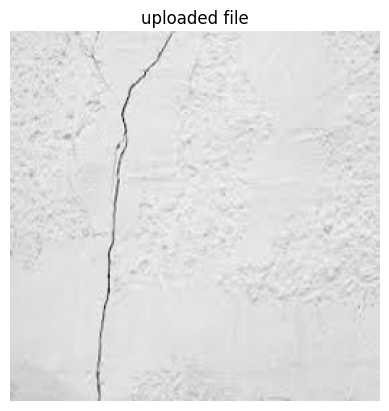

In [79]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files
from PIL import Image
from skimage.color import rgb2gray
from skimage import util
import matplotlib.pyplot as plt

uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename)

#cv rgb ke bgr
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# preprocess
im_frame = Image.fromarray(img_rgb).resize((64*4, 64*4))
image = (255 * rgb2gray(np.array(im_frame))).astype(np.uint8)
imaged = util.img_as_ubyte(image)
plt.imshow(imaged, cmap='gray')
plt.title('uploaded file')
plt.axis('off')
plt.show()

In [80]:
sample = glcm_process(filename,path='/content/')
sample = np.array(sample).reshape(1,5)
# sample
sample

array([[1.38818009e+02, 7.19300881e+00, 1.57451897e-01, 5.27841700e-02,
        2.67934952e-02]])

In [81]:
import numpy as np

sample_scaled = scaler.transform(sample)
pred = model.predict(sample_scaled)
print("Prediksi crack:", pred[0][0])

if pred[0][0] < 0.5:
  print("tidak retak")
else:
  print("retak nih 😂")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prediksi crack: 0.22252238
tidak retak


X does not have valid feature names, but StandardScaler was fitted with feature names
